In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.15'

## Creating Disk Models from Disk Parameters

In [2]:
# Imports

from disk_utils_jax import jax_model
# Dust Distribution Function
from SLD_utils import DustEllipticalDistribution2PowerLaws
# Scattering Phase Functions
from SLD_utils import HenyeyGreenstein_SPF, DoubleHenyeyGreenstein_SPF, InterpolatedUnivariateSpline_SPF, GAUSSIAN_PSF

In [3]:
# Parameters
disk_params = {}
disk_params['inclination'] = 40. #In degrees
disk_params['position_angle'] = 50. #In Degrees
disk_params['alpha_in'] = 8. #The inner power law
disk_params['alpha_out'] = -5. #The outer power law
disk_params['flux_scaling'] = 1e6
disk_params['sma'] = 30. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

In [4]:
# This depends on the function
spf_params_HG = HenyeyGreenstein_SPF.params   # Gets default parameters: {'g', 0.3}
spf_params_DHG = DoubleHenyeyGreenstein_SPF.params
spf_params_IUS = InterpolatedUnivariateSpline_SPF.params

disk_image_HG = jax_model(DustEllipticalDistribution2PowerLaws, HenyeyGreenstein_SPF, disk_params, spf_params_HG)
disk_image_DHG = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params, spf_params_DHG)
disk_image_IUS = jax_model(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, disk_params, spf_params_IUS)

#### Showing Disk Images

Text(0.5, 1.0, 'Interpolated Univariate Spline')

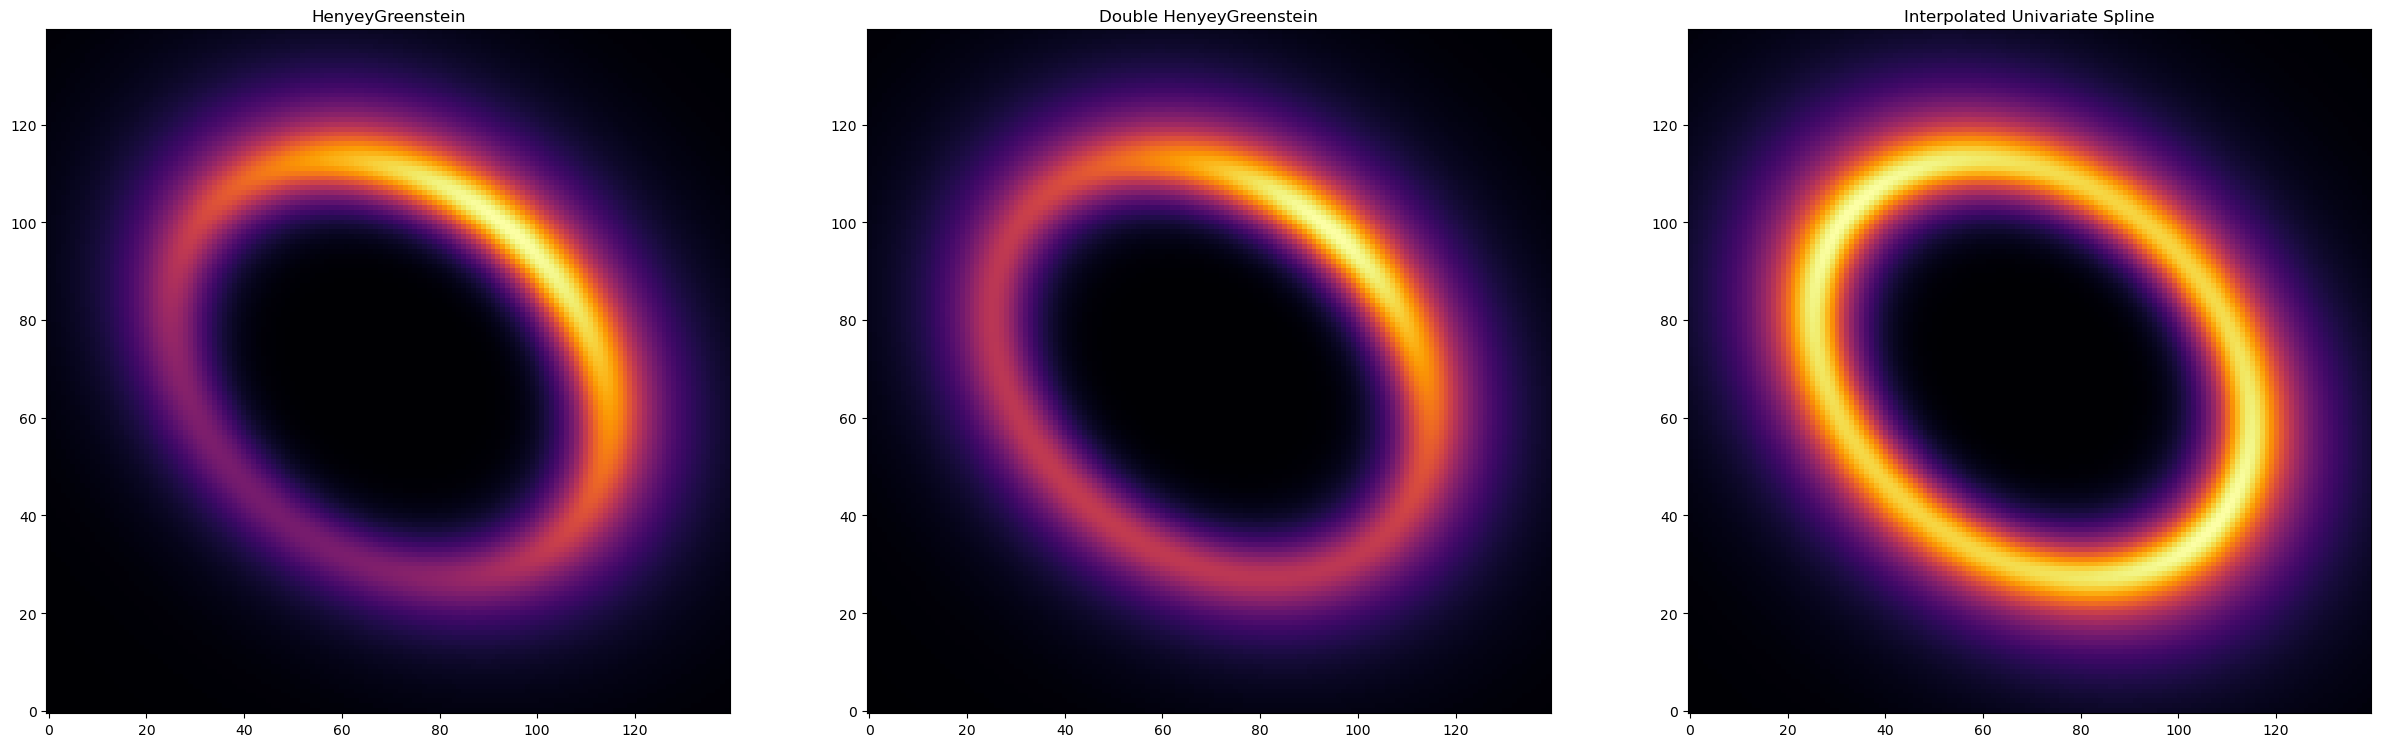

In [5]:
fig, axes = plt.subplots(1,3, figsize=(30,20))

im = axes[0].imshow(disk_image_HG, origin='lower', cmap='inferno')
axes[0].set_title("HenyeyGreenstein")

im = axes[1].imshow(disk_image_DHG, origin='lower', cmap='inferno')
axes[1].set_title("Double HenyeyGreenstein")

im = axes[2].imshow(disk_image_IUS, origin='lower', cmap='inferno')
axes[2].set_title("Interpolated Univariate Spline")

### Generating Target Disks with Noise

In [6]:
# Parameters
target_disk_params = {}
target_disk_params['inclination'] = 60. #In degrees
target_disk_params['position_angle'] = 30. #In Degrees
target_disk_params['alpha_in'] = 6. #The inner power law
target_disk_params['alpha_out'] = -7. #The outer power law
target_disk_params['flux_scaling'] = 1e6
target_disk_params['sma'] = 50. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

target_spf_params = {'g1': 0.2, 'g2': 0.5, 'weight': 0.45}

# Target Disk Model Image
target_image_orig = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params, target_spf_params)

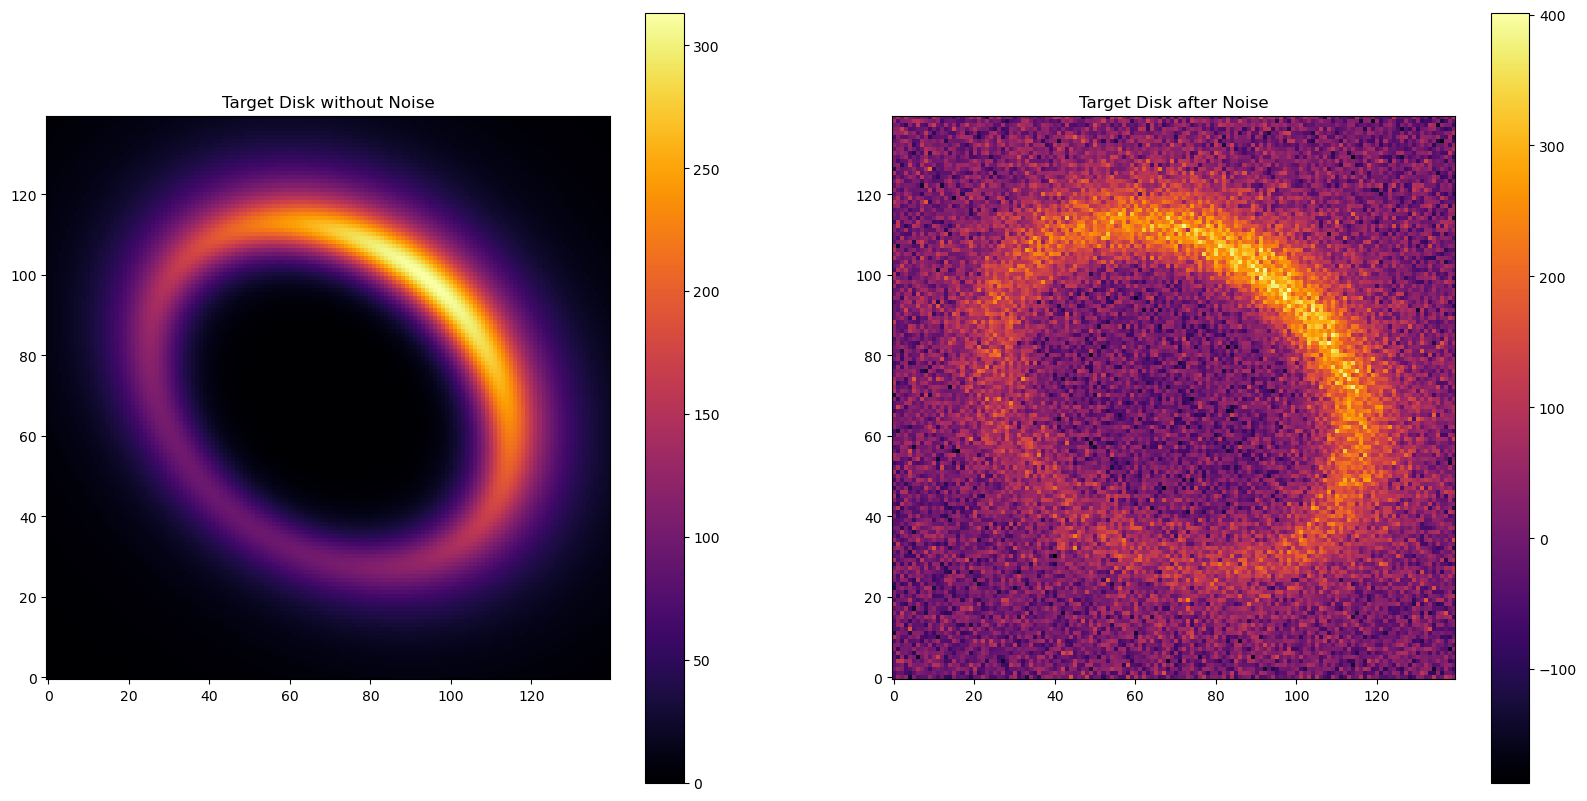

In [7]:
noise_level = 50
noise = np.random.normal(0, noise_level, target_image_orig.shape)

# Target Image
target_image = target_image_orig + noise

fig, axes = plt.subplots(1,2, figsize=(20,10))

im = axes[0].imshow(target_image_orig, origin='lower', cmap='inferno')
axes[0].set_title("Target Disk without Noise")
plt.colorbar(im,ax=axes[0])

im = axes[1].imshow(target_image, origin='lower', cmap='inferno')
axes[1].set_title("Target Disk after Noise")
plt.colorbar(im,ax=axes[1])

## Comparing Disk Images to Target Disk Image using Log-Likelood

In [8]:
from regression import log_likelihood_image

# Creating error map
err_map = jnp.ones(target_image.shape)*noise_level

# Comparing generated disk image to target image
print("Closer to 0 means better fit!")
print("HenyeyGreenstein Image Log-Likelihood: " + str(log_likelihood_image(disk_image_HG, target_image, err_map)))
print("Double HenyeyGreenstein Image Log-Likelihood: " + str(log_likelihood_image(disk_image_DHG, target_image, err_map)))
print("Interpolated Univariate Spline Image Log-Likelihood: " + str(log_likelihood_image(disk_image_IUS, target_image, err_map)))

Closer to 0 means better fit!
HenyeyGreenstein Image Log-Likelihood: -86560.49
Double HenyeyGreenstein Image Log-Likelihood: -87289.305
Interpolated Univariate Spline Image Log-Likelihood: -4319589.0


In [9]:
# You can create and compare a set of parameters directly to the target image
from regression import log_likelihood, log_likelihood_1d_pos_all_pars, log_likelihood_1d_pos_all_pars_spline

print(log_likelihood(DustEllipticalDistribution2PowerLaws, HenyeyGreenstein_SPF, disk_params, spf_params_HG, target_image, err_map))

# log_likelihood_1d_pos_all_pars takes 1D jax/numpy arrays instead of dictionaries so it can be used in optimization methods
# it also returns a positive log-likelihood for the same reason
# it doesn't work with spline_spfs
disk_params_1d = np.array([disk_params['alpha_in'], disk_params['alpha_out'], disk_params['sma'], disk_params['inclination'],
                           disk_params['position_angle']]) # have to put values in this specific order (flux scaling is not included in the array)
spf_params_HG_1d = HenyeyGreenstein_SPF.pack_pars(spf_params_HG)  # Non-spline spf parameter arrays can be made like this
all_pars = jnp.concatenate([disk_params_1d, spf_params_HG_1d])
print(log_likelihood_1d_pos_all_pars(all_pars, DustEllipticalDistribution2PowerLaws, HenyeyGreenstein_SPF, disk_params['flux_scaling'],
                                        target_image, err_map))

# log_likelihood_1d_pos_all_pars_spline is the same as log_likelihood_1d_pos_all_pars except it only works with splines
# spline parameters are an array of the y positions to knots, by default, the number of knots is 6
# the knot x positions are defined by jnp.linspace(0, np.pi, KNOTS)   KNOTS being the amount of knots
spline_params_1d= jnp.full(6, 0.05)   # random knot y-values
all_pars_spline = jnp.concatenate([disk_params_1d, spline_params_1d])
print(log_likelihood_1d_pos_all_pars_spline(all_pars_spline, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, 
                        disk_params['flux_scaling'], target_image, err_map))

-86560.49
86560.49
91540.14


## Fitting Disks to Target Image

In [10]:
from scipy.optimize import minimize

# Non-spline spf function (the spf might not work for the disk image)
llp = lambda x: log_likelihood_1d_pos_all_pars(x, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params['flux_scaling'],
                                                target_image, err_map)

# Spline spf function (should work for all disk images)
llp_spline = lambda x: log_likelihood_1d_pos_all_pars_spline(x, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF,
                                                        disk_params['flux_scaling'], target_image, err_map)

# Note: you can use lambda arguments to optimize almost anything in the likelihood function

# Using Nelder-Mead method (Other methods that use gradient aren't as consistent right now)
spf_params_DHG_1d = DoubleHenyeyGreenstein_SPF.pack_pars(spf_params_DHG)
all_pars = jnp.concatenate([disk_params_1d, spf_params_DHG_1d])
soln_DHG = minimize(llp, all_pars, method = "Nelder-Mead")

# Using values from previous code block as initial guesses
opt = {'disp':True,'maxiter':1000}
soln_spline = minimize(llp_spline, all_pars_spline, options=opt, method = "Nelder-Mead")

print(soln_DHG)
print(soln_spline)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 86374.390625
             x: [ 7.753e+00 -5.128e+00  3.005e+01  3.947e+01  5.036e+01
                  3.877e-01 -2.457e-01  9.393e-01]
           nit: 220
          nfev: 408
 final_simplex: (array([[ 7.753e+00, -5.128e+00, ..., -2.457e-01,
                         9.393e-01],
                       [ 7.753e+00, -5.128e+00, ..., -2.457e-01,
                         9.393e-01],
                       ...,
                       [ 7.753e+00, -5.128e+00, ..., -2.457e-01,
                         9.393e-01],
                       [ 7.753e+00, -5.128e+00, ..., -2.457e-01,
                         9.393e-01]], dtype=float32), array([ 8.637e+04,  8.637e+04,  8.637e+04,  8.637e+04,
                        8.637e+04,  8.637e+04,  8.637e+04,  8.637e+04,
                        8.637e+04]))
       message: Maximum number of iterations has been exceeded.
       success: False
        stat

/tmp/ipykernel_1789602/2826230090.py:20: RuntimeWarning: Maximum number of iterations has been exceeded.
  soln_spline = minimize(llp_spline, all_pars_spline, options=opt, method = "Nelder-Mead")


In [11]:
# can convert the array back into dictionaries or just directly model image
from disk_utils_jax import jax_model_all_1d

disk_image_fit_DHG = jax_model_all_1d(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, soln_DHG.x[0:5],
                                            soln_DHG.x[5:], disk_params['flux_scaling'])

# Have to input spline parameters like this for the method to work
disk_image_fit_spline = jax_model_all_1d(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, soln_spline.x[0:5],
                                            InterpolatedUnivariateSpline_SPF.pack_pars(soln_spline.x[5:]), disk_params['flux_scaling'])

Text(0.5, 1.0, 'Target Image')

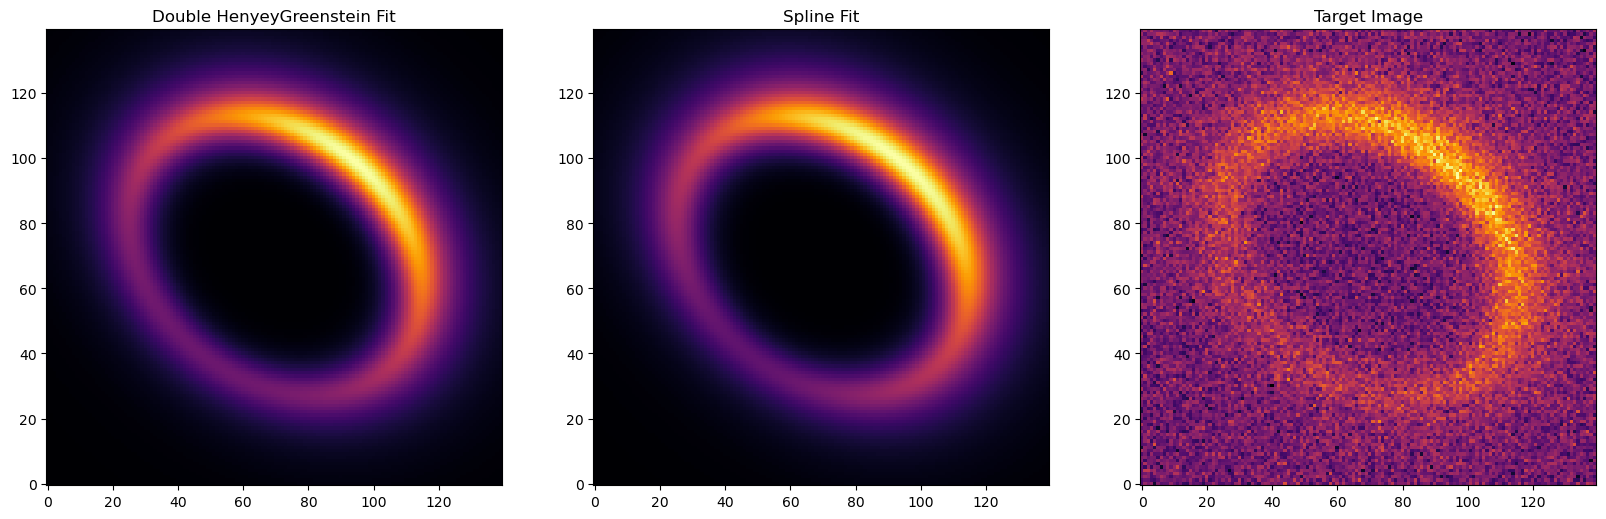

In [12]:
fig, axes = plt.subplots(1,3, figsize=(20,10))

im = axes[0].imshow(disk_image_fit_DHG, origin='lower', cmap='inferno')
axes[0].set_title("Double HenyeyGreenstein Fit")

im = axes[1].imshow(disk_image_fit_spline, origin='lower', cmap='inferno')
axes[1].set_title("Spline Fit")

im = axes[2].imshow(target_image, origin='lower', cmap='inferno')
axes[2].set_title("Target Image")

## Convoluting Models with PSFs

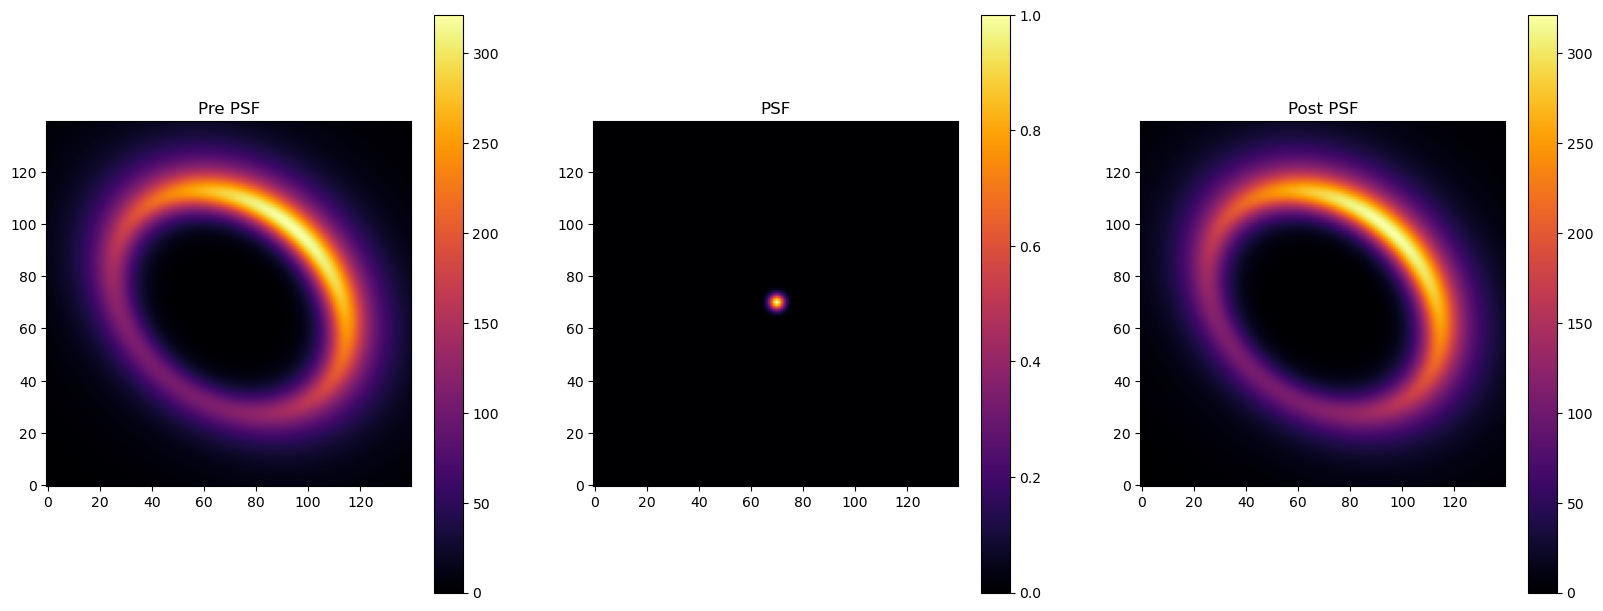

In [13]:

disk_image_orig = jax_model(DustEllipticalDistribution2PowerLaws, HenyeyGreenstein_SPF, disk_params, spf_params_HG)

# Default x_vector, y_vector for disk models we are working with
x_vector = (jnp.arange(0, 140) - 70)*0.01225*50.
y_vector = (jnp.arange(0, 140) - 70)*0.01225*50.

psf_image = GAUSSIAN_PSF.generate(jnp.meshgrid(x_vector, y_vector))

disk_image_psf = jax_model(DustEllipticalDistribution2PowerLaws, HenyeyGreenstein_SPF, disk_params, spf_params_HG, PSFModel=GAUSSIAN_PSF)

fig, axes = plt.subplots(1,3, figsize=(20,10))

im = axes[0].imshow(disk_image_orig, origin='lower', cmap='inferno')
axes[0].set_title("Pre PSF")
plt.colorbar(im,ax=axes[0], shrink = 0.75)

im = axes[1].imshow(psf_image, origin='lower', cmap='inferno')
axes[1].set_title("PSF")
plt.colorbar(im,ax=axes[1], shrink = 0.75)

im = axes[2].imshow(disk_image_psf, origin='lower', cmap='inferno')
axes[2].set_title("Post PSF")
plt.colorbar(im,ax=axes[2], shrink = 0.75)